# Proglearn: Scene Segmentation
*Neuro Data Design I: Spring 2022*


This tutorial provides a walkthrough to applying a Random Forest model based on Proglearn to perform scene segmentation on the ADE20K image dataset. First, we examine the accuracy of currently-used packages, after which we will work to use Proglearn.


**Contributor**: Amy van Ee (avanee1@jhu.edu)

# I. Preprocessing of Images

In this first section, we will import our images from the ISIC dataset.

In [1]:
#========================================================#
# retrieve data

import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt

# location of data
dataloc = 'C:/Users/Amy/Documents/Python/Neuro Data Design/'

# extract images
datalbl = dataloc + 'NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/'
dataimg = dataloc + 'NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/'

lblpaths = [datalbl+im for im in os.listdir(datalbl)]
imgpaths = [dataimg+im for im in os.listdir(dataimg)]

# sort and print information
imgpaths.sort()
lblpaths.sort()
print('Total # of images =', len(imgpaths))
print('Total # of labels =', len(lblpaths))
imgpaths[:5], lblpaths[:5]

Total # of images = 1279
Total # of labels = 1279


(['C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000000.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000001.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000002.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000003.jpg',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000004.jpg'],
 ['C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000000_Segmentation.png',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000001_Segmentation.png',
  'C:/Users/Amy/Documents/Python/Neuro Data Design/NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000002_Segmentation.png',
  'C:/Users

# II. Current Methods of Scene Segmentation

To test other methods of scene segmentation before we attempt an implementation of ProgLearn, we will use scikit-image. 

**Visualize an Example Image**

We will choose a sample image from the ISIC dataset to confirm that this method works.

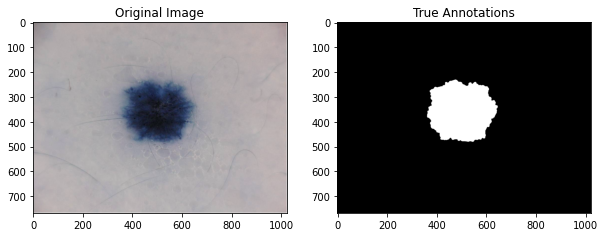

In [2]:
#========================================================#
# Plot the original image alongside the annotated image

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

image = cv2.imread(imgpaths[1])
label = cv2.imread(lblpaths[1]) 
ax[0].imshow(image)
ax[0].set_title("Original Image")

ax[1].imshow(label)
ax[1].set_title("True Annotations")
plt.show()

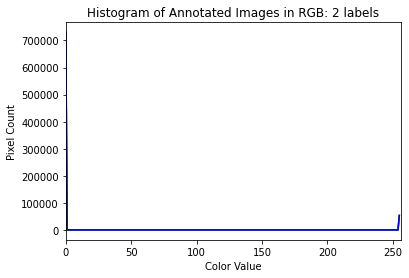

In [3]:
#========================================================#
# Show a histogram of the image

# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        label[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color Value")
plt.ylabel("Pixel Count")
plt.title("Histogram of Annotated Images in RGB: %d labels" %(np.unique(label).size))

plt.show()

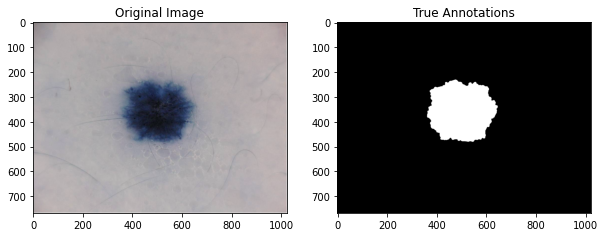

In [4]:
#========================================================#
# Convert to greyscale

from skimage.color import rgb2gray

image_grey = rgb2gray(image)
label_grey = rgb2gray(label)
label_grey = label_grey * 1000
label_grey = label_grey.astype(int)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

ax[0].imshow(image[:,:], cmap = plt.cm.gray)
ax[0].set_title("Original Image")

ax[1].imshow(label[:,:], cmap = plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

Text(0, 0.5, 'Pixel Count')

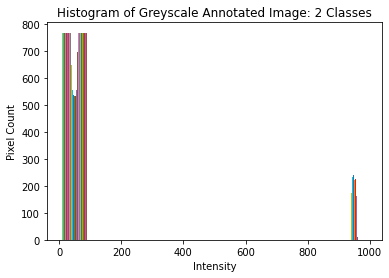

In [29]:
#========================================================#
# Show a histogram of the grey-scale image

plt.hist(label_grey)
plt.title("Histogram of Greyscale Annotated Image: %d Classes" %(np.unique(label_grey).size))
plt.xlabel("Intensity")
plt.ylabel("Pixel Count")

**Performing the Image Segmentation**

After this prepration and analysis of the images, we will now attempt to perform scene segmentation.

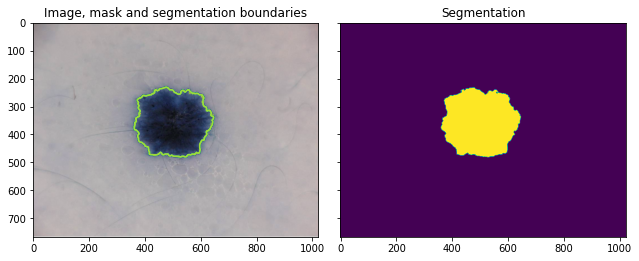

In [5]:
# ========================================================#
# Use scikit-image to perform Image Segmentation

# import packages
from skimage import segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

img = image

training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
training_labels = np.add(label_grey, training_labels) 
training_labels[training_labels == 0] = 1 # needs to be something besides 0

sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
features = features_func(img)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

# result will be array of 1, 1000 (1000 is lesion)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result)
ax[1].set_title('Segmentation')
fig.tight_layout()

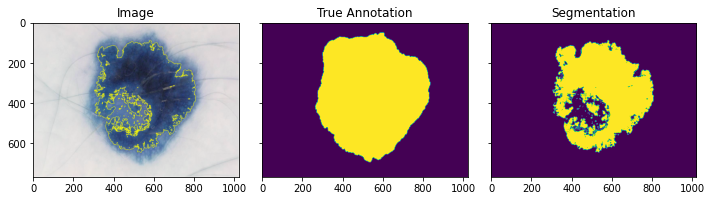

In [8]:
# test out one new image

img_new = cv2.imread(imgpaths[3])
label_new = cv2.imread(lblpaths[3])

label_grey_new = rgb2gray(label_new)
label_grey_new = label_grey_new * 1000
label_grey_new = label_grey_new.astype(int)

features_new = features_func(img_new)
result_new = future.predict_segmenter(features_new, clf)
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 6))


ax[0].imshow(segmentation.mark_boundaries(img_new, result_new, mode='thick'))
ax[0].set_title('Image')
ax[1].imshow(label_grey_new)
ax[1].set_title('True Annotation')
ax[2].imshow(result_new)
ax[2].set_title('Segmentation')
fig.tight_layout()

plt.show()

**Analyzing Accuracy**

We will next analyze the performance of scikit-image by computing the accuracy. We will do so by comparing the result from scene segmentation and the true annotated image.

Adapted Rand error: 0.009862220915348052
Adapted Rand precision: 0.9804681852413315
Adapted Rand recall: 1.0
False Splits: 0.01419788863851523
False Merges: 0.013918781384679241
Dice Coefficient: 0.9985814046645252


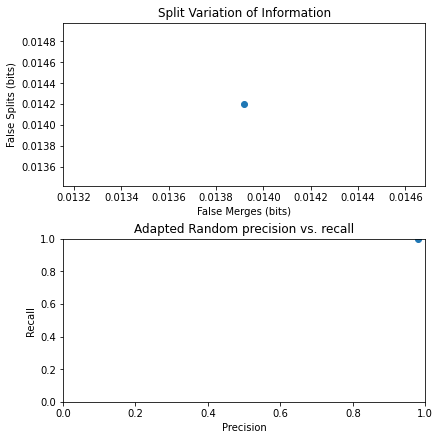

In [9]:
#========================================================#
# Analyze the accuracy by looking at 
# precision, recall, false splits, false merges, dice score

from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
def get_dice(true, test):
    return np.size(test[test == true]) * 2.0 / (np.size(true) + np.size(test))

result[result == 1] = 0 # correction

error, precision, recall = adapted_rand_error(label_grey, result)
splits, merges = variation_of_information(label_grey, result)
dice = get_dice(label_grey, result)
print(f'Adapted Rand error: {error}')
print(f'Adapted Rand precision: {precision}')
print(f'Adapted Rand recall: {recall}')
print(f'False Splits: {splits}')
print(f'False Merges: {merges}')
print(f'Dice Coefficient: {dice}')

fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merges, splits)
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision, recall)
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Random precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

plt.show()

**Performing Scene Segmentation on entire dataset**

C:\Users\Amy\AppData\Local\Temp\ipykernel_124192\3653255971.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])


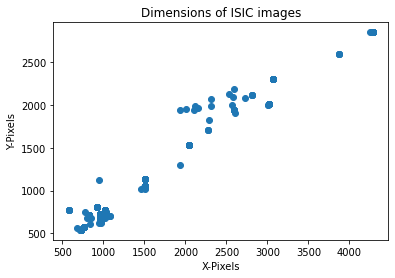

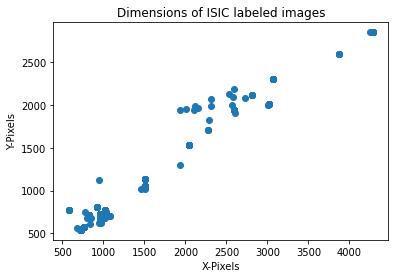

In [9]:
# get all images
# images = [cv2.imread(imgpaths[i]) for i in np.arange(len(imgpaths))]
# labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])

images = [cv2.imread(imgpaths[i]) for i in np.arange(len(imgpaths))]
labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])



# get dimensions of dataset
xdim_images = [np.shape(img)[1] for img in images]
ydim_images = [np.shape(img)[0] for img in images]

xdim_labels = [np.shape(lbl)[1] for lbl in labels_grey]
ydim_labels = [np.shape(lbl)[0] for lbl in labels_grey]

# make a plot
plt.scatter(xdim_images, ydim_images)
plt.title("Dimensions of ISIC images")
plt.xlabel("X-Pixels")
plt.ylabel("Y-Pixels")
plt.show()

# make a plot
plt.scatter(xdim_labels, ydim_labels)
plt.title("Dimensions of ISIC labeled images")
plt.xlabel("X-Pixels")
plt.ylabel("Y-Pixels")
plt.show()

In [11]:
#========================================================#
# perform scene segmentation on all images

# initialize arrays
error_list = np.zeros(len(images))
precision_list = np.zeros(len(images))
recall_list = np.zeros(len(images))
splits_list = np.zeros(len(images))
merges_list = np.zeros(len(images))
dice_list = np.zeros(len(images))
result_list = np.zeros(len(images), dtype = object)

# loop through each image and determine values
for i in np.arange(len(images[1:100])):
    # use classifier
    features = features_func(images[i])
    result = future.predict_segmenter(features, clf)
    result[result == 1] = 0 # correction for when compare to true

    # assess
    error, precision, recall = adapted_rand_error(labels_grey[i], result)
    splits, merges = variation_of_information(labels_grey[i], result)
    dice = get_dice(labels_grey[i], result)

    # add to list
    error_list[i] = error
    precision_list[i] = precision
    recall_list[i] = recall
    splits_list[i] = splits
    merges_list[i] = merges
    dice_list[i] = dice
    result_list[i] = result

MemoryError: Unable to allocate 291. MiB for an array with shape (1129, 1504, 45) and data type float32